In [ ]:
import tensorflow as tf

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
data_file = 'normalised_indicators_9.xlsx'
df = pd.read_excel(data_file)

In [ ]:
df = pd.DataFrame(df)
df.index = df.pop('Date')

In [ ]:
df

,GDP,Interest Rates,PPI,CPI
Date,,,,
1963 Q2,0.425107,0.631579,0.529196,0.430144
1963 Q3,0.414541,0.631579,0.533134,0.434695
1963 Q4,0.425813,0.635756,0.529984,0.432420
1964 Q1,0.405307,0.629073,0.530771,0.427869
1964 Q2,0.424737,0.619048,0.526834,0.425594
...,...,...,...,...
2022 Q3,0.596212,0.658312,0.458369,0.685838
2022 Q4,0.650822,0.795322,0.344112,0.497600
2023 Q1,0.187054,0.568087,0.449998,0.635491


In [ ]:
df_CPI =  pd.DataFrame(df["CPI"])

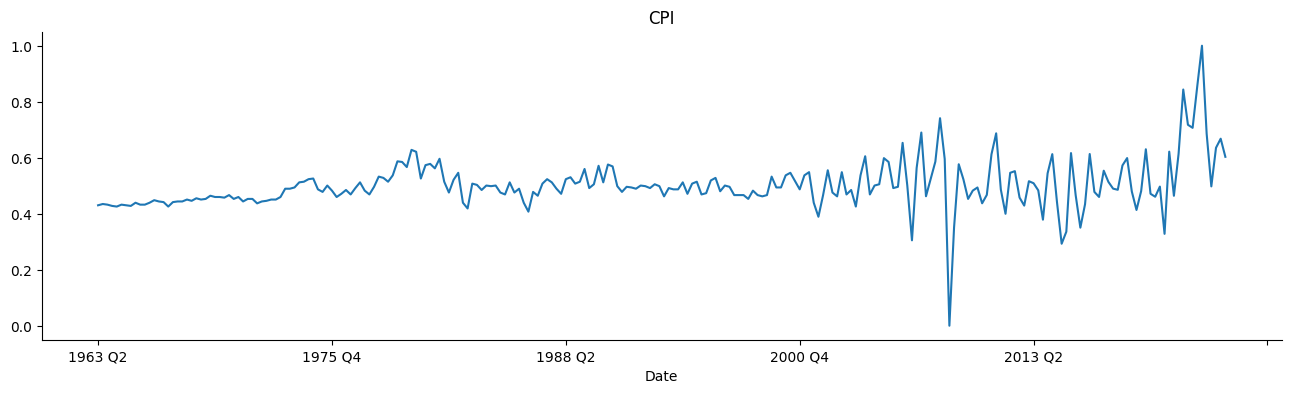

In [ ]:
from matplotlib import pyplot as plt
df_CPI['CPI'].plot(kind='line', figsize=(16, 4), title='CPI')
plt.gca().spines[['top', 'right']].set_visible(False)

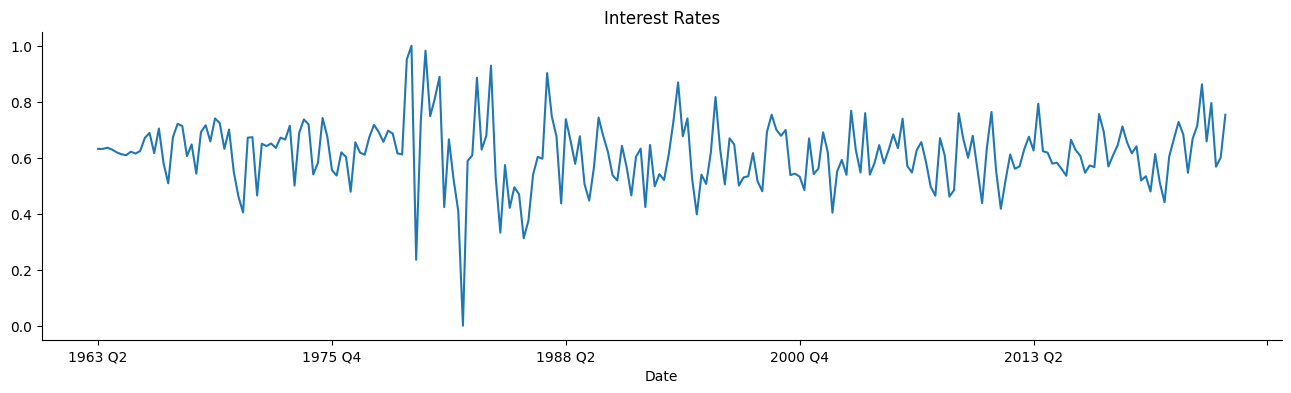

In [ ]:
df_unrate =  pd.DataFrame(df["Interest Rates"])
df_unrate['Interest Rates'].plot(kind='line', figsize=(16, 4), title='Interest Rates')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
def df_to_X_y(df,window_size=8):
  df_as_np = df.to_numpy()
  date_as_np = df_date.to_numpy()
  X=[]
  y=[]
  date_data=[]
  for i in range(len(df_as_np)-window_size):
    rows = [a for a in df_as_np[i:i+window_size]]
    X.append(rows)
    output_row=  df_as_np[i+window_size]
    label = output_row[3]
    date = date_as_np[i+window_size]
    y.append(label)
    date_data.append(date)
  return np.array(X),np.array(y),np.array(date_data)

In [ ]:
date_data= df.index


In [ ]:
df_date = pd.DataFrame(date_data)


In [ ]:
WINDOW_SIZE = 6
X, y ,date_window= df_to_X_y(df,WINDOW_SIZE)

In [ ]:
train_size = int(0.7 * len(X))
val_size = int(0.1 * len(X))

In [ ]:
X_train, y_train = X[:train_size], y[:train_size]
X_val , y_val = X[train_size: train_size + val_size], y[train_size: train_size + val_size]
X_test ,y_test = X[train_size + val_size:], y[train_size + val_size:]

In [ ]:
date_train = date_window[:train_size]
date_val  = date_window[train_size: train_size + val_size]
date_test  = date_window[train_size + val_size:]

In [ ]:
X_test.shape, y_test.shape, date_test.shape

((48, 6, 4), (48,), (48, 1))

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

In [ ]:
from sklearn.metrics import mean_squared_error as mse
import numpy as np
import matplotlib.pyplot as plt

def plot_predictions1(model, X, y, date):
    predictions = model.predict(X).flatten()
    date = date.flatten().tolist()

    # Calculate the index to start calculating MSE and RMSE from
    start_index = date.index('2011 Q4')

    # Manually add 2011 Q1, Q2, Q3 to the beginning of the date array
    date = ['2011 Q1', '2011 Q2', '2011 Q3'] + date[start_index:]
    predictions = [None, None, None] + predictions.tolist()[start_index:]
    y = [None, None, None] + y.tolist()[start_index:]

    df_graph = pd.DataFrame(data={'Predictions': predictions, 'Actuals': y})

    total_error = 0  # Initialize total error to calculate average error
    num_valid_samples = 0  # Initialize count of valid samples (non-None)
    rmse_values=[]

    for i, (pred, actual) in enumerate(zip(predictions, y)):
      if pred is not None and actual is not None:
        error = mse([actual], [pred])  # Calculate MSE for current prediction and actual value
        rmse = np.sqrt(error)
        print(f"Prediction {i+1}: {pred}, Actual: {actual}, MSE: {error}, RMSE: {rmse}")
        total_error += error
        num_valid_samples += 1
        rmse_values.append(rmse)

    avg_error = total_error / num_valid_samples  # Calculate average error using only valid samples
    final_rmse = np.sqrt(avg_error)
    print(f"Average MSE: {avg_error}")
    print("Final RMSE: ", final_rmse)

    plt.figure(figsize=(48, 25))
    plt.plot(date, df_graph['Predictions'], label='Predictions', color='red')  # Specify color for predictions
    plt.plot(date, df_graph['Actuals'], label='Actuals', color='blue')  # Specify color for actual values
    plt.legend(fontsize=40)  # Add legend to the plot
    plt.xlabel('Date', fontsize=45)
    plt.ylabel('Value', fontsize=45)
    plt.title('Predictions vs Actuals', fontsize=50)
    plt.xticks(fontsize=30)  # Change font size of x-axis ticks
    plt.yticks(fontsize=35)
    plt.grid(True)

    # Set x-axis ticks to show only the selected quarters
    plt.xticks(date[::4])

    plt.show()

    return df_graph, mse([x for x in y if x is not None], [x for x in predictions if x is not None]), final_rmse, rmse_values


In [ ]:
import random
def get_hyper_param(iterations_no):
  hyper_param = [] #lstm1_neurons, lstm2_neurons, lstm3_neurons, dense_neurons, dense2_neurons, learning_rate, epochs, batch_size
  for i in range(iterations_no):
    current_params = []
    current_params.append(np.random.randint(8,513))  #lstm1_neurons
    current_params.append(np.random.randint(8,513))  # lstm2_neurons
    current_params.append(np.random.randint(8,513))  # lstm3_neurons
    current_params.append(np.random.randint(8,513))  # dense_neurons
    current_params.append(np.random.randint(8,513)) # dense2_neurons
    current_params.append(random.choice([0.00001,0.0001,0.001,0.01,0.1])) #learning rate
    current_params.append(random.choice([100,150,200])) #epochs
    current_params.append(random.choice([8,16,32,64,128])) #batch size
    hyper_param.append(current_params)

  return hyper_param

hyper_parameter = get_hyper_param(100)
hyper_parameter


[[488, 494, 415, 388, 82, 0.01, 100, 64],
 [241, 379, 356, 454, 494, 0.1, 100, 64],
 [396, 449, 8, 413, 43, 1e-05, 200, 32],
 [26, 464, 196, 349, 140, 0.01, 150, 128],
 [117, 8, 216, 205, 56, 0.001, 200, 64],
 [117, 440, 138, 109, 135, 0.1, 100, 32],
 [238, 458, 145, 403, 119, 1e-05, 100, 32],
 [291, 168, 419, 122, 485, 1e-05, 200, 128],
 [155, 258, 180, 195, 463, 1e-05, 150, 128],
 [29, 261, 101, 280, 401, 0.0001, 100, 64],
 [492, 476, 314, 172, 248, 0.01, 200, 128],
 [483, 439, 328, 481, 498, 0.1, 150, 8],
 [422, 314, 396, 61, 227, 0.01, 150, 8],
 [190, 276, 232, 429, 168, 0.0001, 200, 64],
 [237, 181, 35, 316, 438, 0.0001, 150, 32],
 [246, 393, 118, 104, 174, 0.01, 100, 16],
 [141, 181, 21, 40, 381, 0.01, 100, 8],
 [269, 294, 153, 297, 420, 0.0001, 100, 128],
 [198, 60, 59, 377, 17, 0.0001, 200, 8],
 [329, 318, 165, 425, 256, 0.1, 150, 16],
 [403, 117, 220, 428, 235, 0.0001, 200, 128],
 [139, 113, 396, 383, 295, 0.0001, 200, 16],
 [485, 169, 270, 509, 75, 0.0001, 150, 64],
 [98, 61,

In [ ]:
train_loss, train_root_mean_sqr_error, val_loss, val_root_mean_sqr_error = list(), list(), list(), list()
best_params =[]
def fit_lstm_random(batch_size):
  min_val_loss = 999
  min_test_loss = 999
  for lstm1_neurons, lstm2_neurons,lstm3_neurons,dense_neurons,dense2_neurons, learning_rate,n_epochs, batch_size in hyper_parameter:
    model = Sequential()
    model.add(LSTM(lstm1_neurons,input_shape=(6,4),return_sequences=True,activation ='tanh'))
    model.add(Dropout(0.0))

    model.add(LSTM(lstm2_neurons,return_sequences = True,activation ='tanh'))
    model.add(Dropout(0.0))

    model.add(LSTM(lstm3_neurons,return_sequences = False,activation ='tanh'))
    model.add(Dropout(0.0))

    model.add(Dense(dense_neurons,activation = 'linear'))
    model.add(Dropout(0.0))

    model.add(Dense(dense2_neurons,activation = 'linear'))
    model.add(Dropout(0.0))

    model.add(Dense(1,activation = "linear"))
    model.compile(loss=MeanSquaredError(),optimizer = Adam(learning_rate=learning_rate),metrics = [RootMeanSquaredError()])
    lstm_model = model.fit(X_train,y_train, validation_data = (X_val,y_val),epochs = n_epochs,batch_size = batch_size,verbose = 2)
    current_val_loss = lstm_model.history['val_loss'][-1]
    test_results = model.evaluate(X_test, y_test, verbose=0)
    current_test_loss = test_results[0]

    if current_val_loss < min_val_loss:
      min_val_loss = current_val_loss
      best_params= [lstm1_neurons, lstm2_neurons,lstm3_neurons,dense_neurons, dense2_neurons, learning_rate,  n_epochs, batch_size]
      print('best_params',best_params)
      print('min_val',min_val_loss)

  print('final best params',best_params)
  print('final best val error',min_val_loss)
  return best_params








In [ ]:
def run_lstm_random():
  n_batch = 80
  history = fit_lstm_random(n_batch)

In [ ]:
run_lstm_random()

Streaming output truncated to the last 5000 lines.
Epoch 2/200
21/21 - 0s - loss: 0.0162 - root_mean_squared_error: 0.1272 - val_loss: 0.0247 - val_root_mean_squared_error: 0.1570 - 194ms/epoch - 9ms/step
Epoch 3/200
21/21 - 0s - loss: 0.0032 - root_mean_squared_error: 0.0565 - val_loss: 0.0237 - val_root_mean_squared_error: 0.1541 - 187ms/epoch - 9ms/step
Epoch 4/200
21/21 - 0s - loss: 0.0019 - root_mean_squared_error: 0.0436 - val_loss: 0.0224 - val_root_mean_squared_error: 0.1495 - 190ms/epoch - 9ms/step
Epoch 5/200
21/21 - 0s - loss: 0.0019 - root_mean_squared_error: 0.0436 - val_loss: 0.0222 - val_root_mean_squared_error: 0.1491 - 178ms/epoch - 8ms/step
Epoch 6/200
21/21 - 0s - loss: 0.0019 - root_mean_squared_error: 0.0438 - val_loss: 0.0229 - val_root_mean_squared_error: 0.1512 - 184ms/epoch - 9ms/step
Epoch 7/200
21/21 - 0s - loss: 0.0018 - root_mean_squared_error: 0.0426 - val_loss: 0.0230 - val_root_mean_squared_error: 0.1516 - 189ms/epoch - 9ms/step
Epoch 8/200
21/21 - 0s - 





lstm1_neurons, lstm2_neurons, dense_neurons, dense2_neurons, learning_rate, lstm1_drop, lstm2_drop, lstm1_activ, lstm2_activ, dense_activ, dense2_activ, epochs, batch_size



In [ ]:
model_tune = Sequential()

model_tune.add(LSTM(186,input_shape=(6,4),return_sequences=True,activation='tanh'))
model_tune.add(Dropout(0.0))

model_tune.add(LSTM(271,return_sequences=True,activation='tanh'))
model_tune.add(Dropout(0.0))

model_tune.add(LSTM(170,return_sequences=False,activation='tanh'))
model_tune.add(Dropout(0.0))


model_tune.add(Dense(178, 'linear'))
model_tune.add(Dropout(0.0))

model_tune.add(Dense(306, 'linear'))
model_tune.add(Dropout(0.0))


model_tune.add(Dense(1, activation='linear'))
model_tune.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_27 (LSTM)              (None, 6, 186)            142104    
                                                                 
 dropout_45 (Dropout)        (None, 6, 186)            0         
                                                                 
 lstm_28 (LSTM)              (None, 6, 271)            496472    
                                                                 
 dropout_46 (Dropout)        (None, 6, 271)            0         
                                                                 
 lstm_29 (LSTM)              (None, 170)               300560    
                                                                 
 dropout_47 (Dropout)        (None, 170)               0         
                                                                 
 dense_27 (Dense)            (None, 178)              

In [ ]:
cp_tune = ModelCheckpoint('model_tune/',save_best_only= True)
model_tune.compile(loss=MeanSquaredError(),optimizer = Adam(learning_rate= 0.001),metrics = [RootMeanSquaredError()])

In [ ]:
model_tune.fit(X_train, y_train,validation_data =(X_val, y_val),epochs = 200,callbacks=[cp_tune],batch_size=8)

Epoch 1/200
21/21 [==============================] - 17s 560ms/step - loss: 0.0338 - root_mean_squared_error: 0.1837 - val_loss: 0.0306 - val_root_mean_squared_error: 0.1748
Epoch 2/200
21/21 [==============================] - 12s 576ms/step - loss: 0.0031 - root_mean_squared_error: 0.0558 - val_loss: 0.0228 - val_root_mean_squared_error: 0.1508
Epoch 3/200
21/21 [==============================] - 0s 12ms/step - loss: 0.0018 - root_mean_squared_error: 0.0427 - val_loss: 0.0240 - val_root_mean_squared_error: 0.1550
Epoch 4/200
21/21 [==============================] - 0s 12ms/step - loss: 0.0022 - root_mean_squared_error: 0.0472 - val_loss: 0.0229 - val_root_mean_squared_error: 0.1513
Epoch 5/200
21/21 [==============================] - 0s 12ms/step - loss: 0.0019 - root_mean_squared_error: 0.0431 - val_loss: 0.0230 - val_root_mean_squared_error: 0.1517
Epoch 6/200
21/21 [==============================] - 0s 12ms/step - loss: 0.0018 - root_mean_squared_error: 0.0428 - val_loss: 0.0230 - 

2/2 [==============================] - 1s 9ms/step
Prediction 4: 0.44881388545036316, Actual: 0.399817995677387, MSE: 0.002400597214645628, RMSE: 0.04899588977297614
Prediction 5: 0.49595120549201965, Actual: 0.5461039699692551, MSE: 0.002515299784709054, RMSE: 0.05015276447723549
Prediction 6: 0.5771912932395935, Actual: 0.5520418609941633, MSE: 0.0006324939422674844, RMSE: 0.025149432245430203
Prediction 7: 0.5210980176925659, Actual: 0.4577181208053507, MSE: 0.004017011329434036, RMSE: 0.06337989688721524
Prediction 8: 0.4693049490451813, Actual: 0.4289841883744573, MSE: 0.0016257637410658024, RMSE: 0.04032076067072399
Prediction 9: 0.5074895024299622, Actual: 0.5161415083608012, MSE: 7.485720662727384e-05, RMSE: 0.008652005930839035
Prediction 10: 0.5275803804397583, Actual: 0.5088840859970065, MSE: 0.0003495514258900712, RMSE: 0.018696294442751782
Prediction 11: 0.459774911403656, Actual: 0.4834262313729735, MSE: 0.0005593849362910377, RMSE: 0.02365131996931752
Prediction 12: 0.46

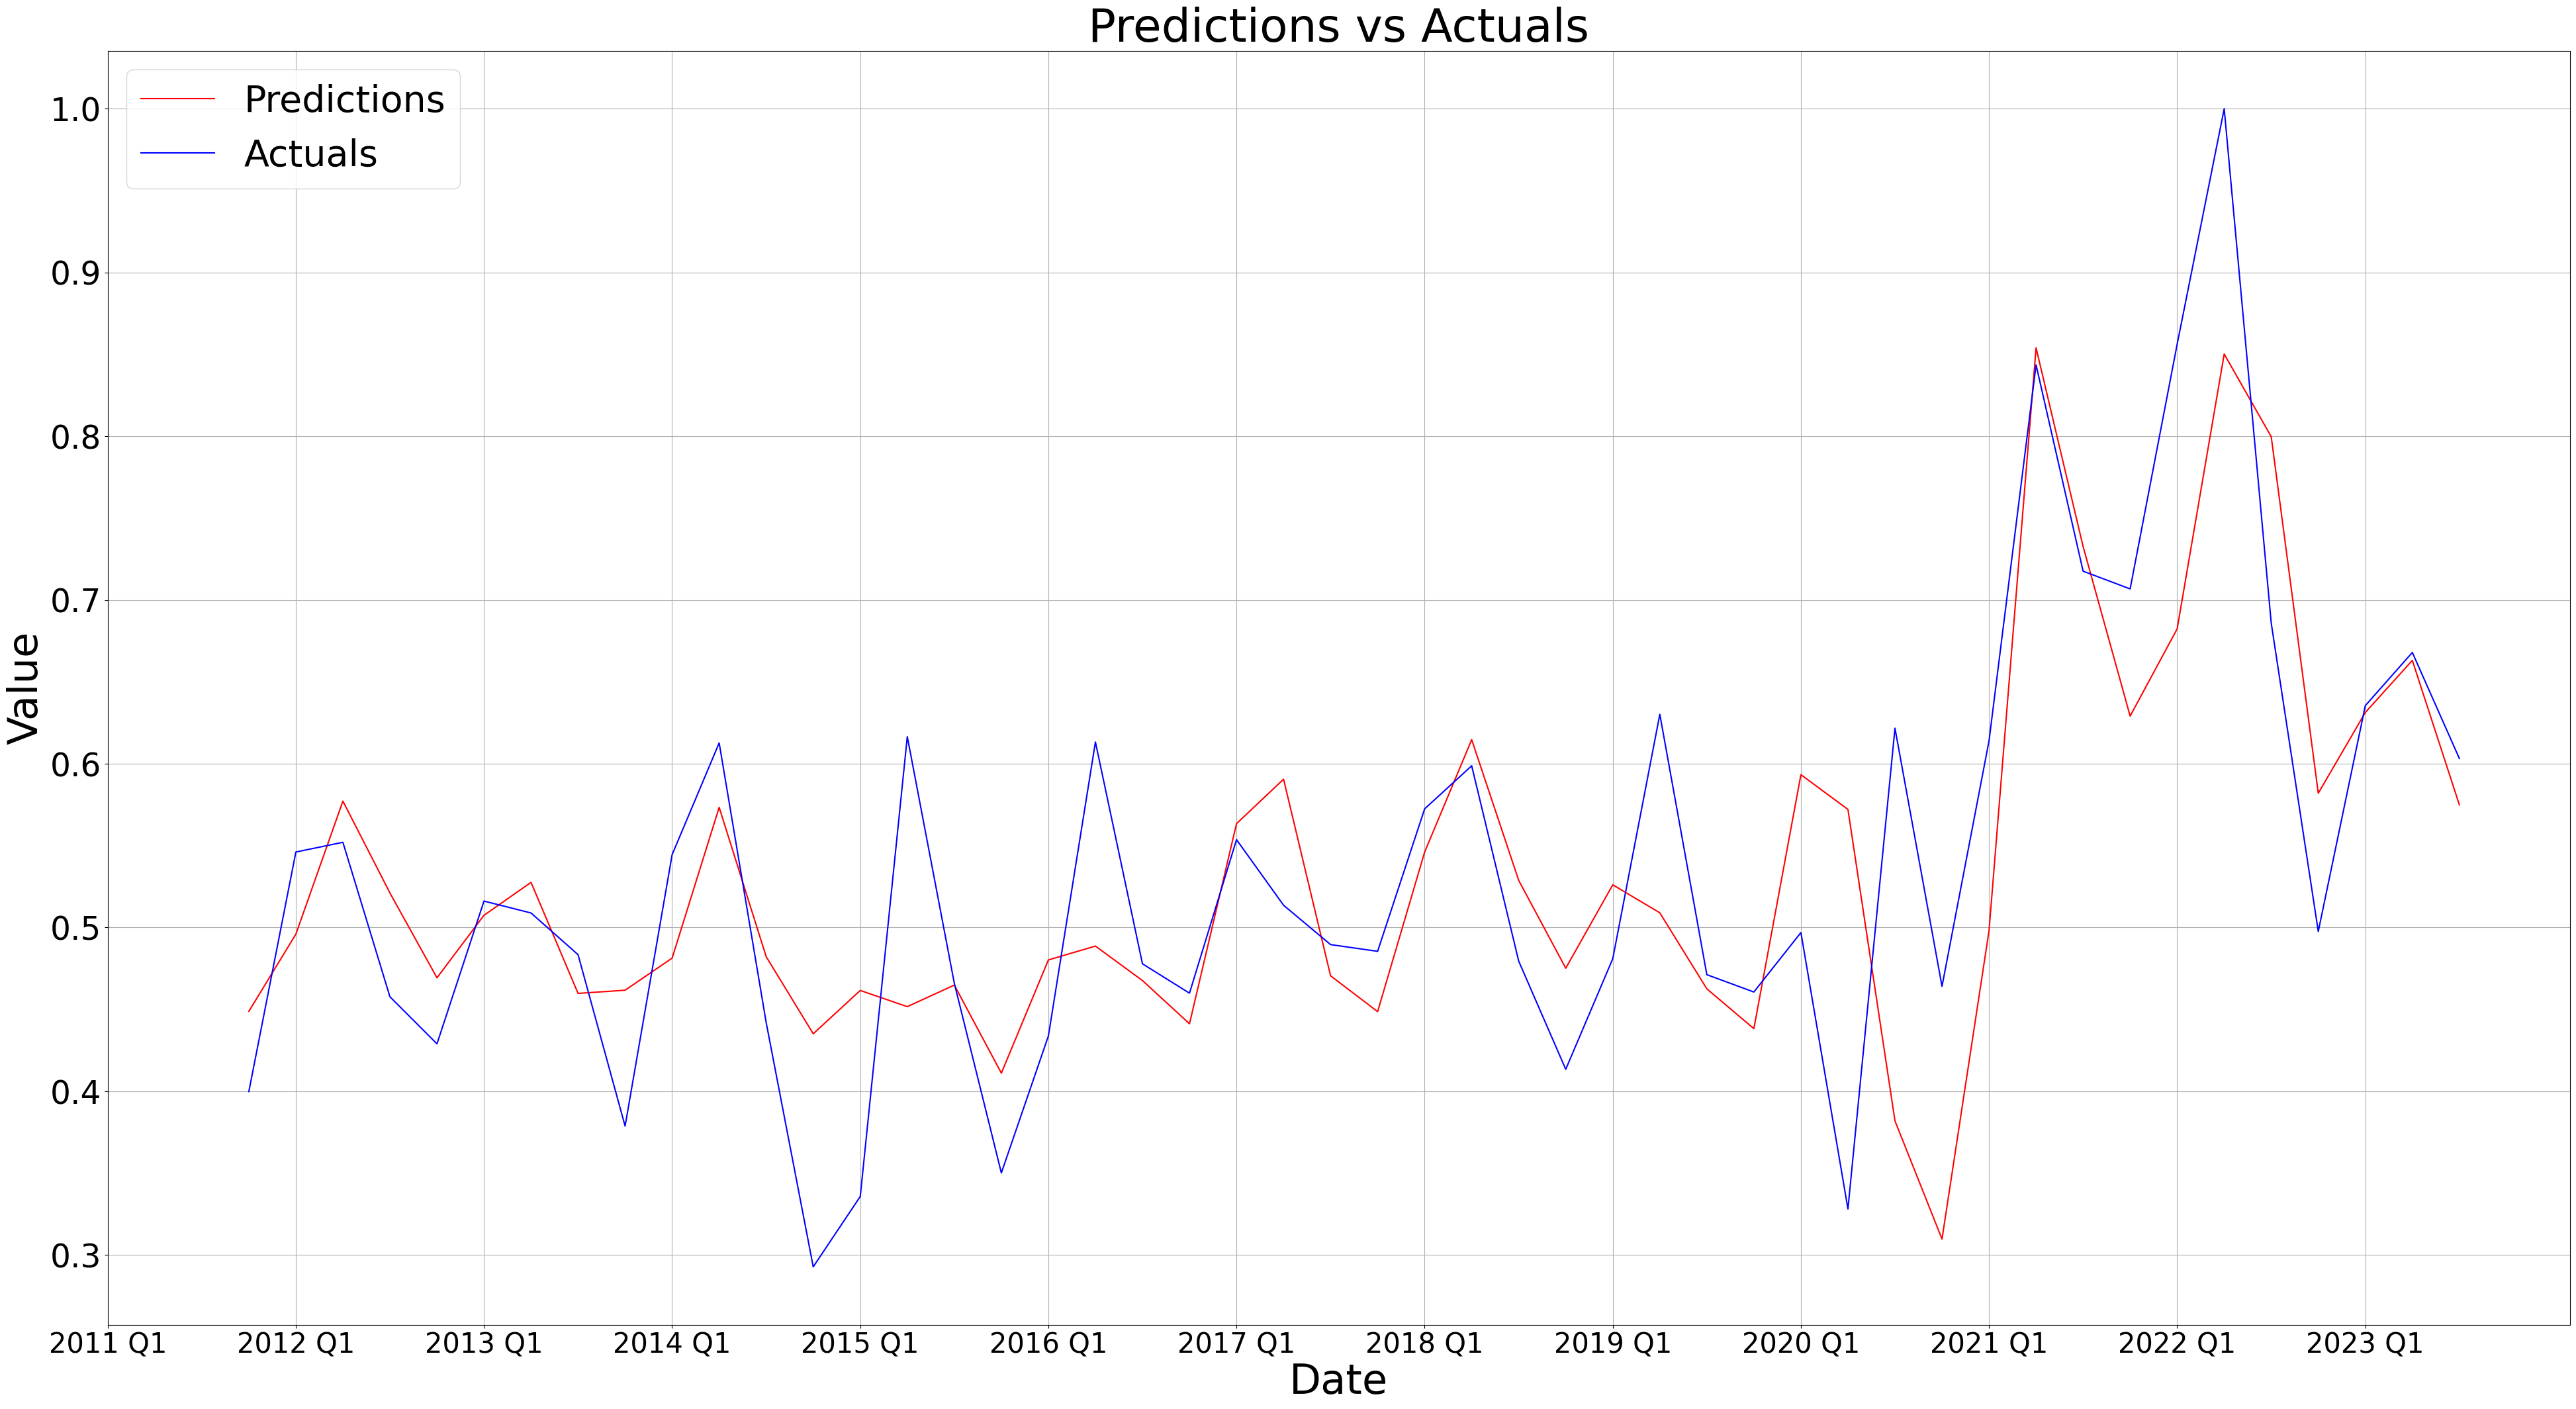

(    Predictions   Actuals
 0           NaN       NaN
 1           NaN       NaN
 2           NaN       NaN
 3      0.448814  0.399818
 4      0.495951  0.546104
 5      0.577191  0.552042
 6      0.521098  0.457718
 7      0.469305  0.428984
 8      0.507490  0.516142
 9      0.527580  0.508884
 10     0.459775  0.483426
 11     0.461722  0.378774
 12     0.481314  0.544489
 13     0.573363  0.612718
 14     0.482193  0.441929
 15     0.435126  0.292799
 16     0.461562  0.335775
 17     0.451703  0.616562
 18     0.464852  0.465931
 19     0.411077  0.350154
 20     0.480215  0.433785
 21     0.488662  0.613264
 22     0.467632  0.477852
 23     0.441232  0.459925
 24     0.563424  0.553657
 25     0.590574  0.513616
 26     0.470529  0.489569
 27     0.448634  0.485474
 28     0.546095  0.572472
 29     0.614723  0.598749
 30     0.528759  0.479468
 31     0.475159  0.413423
 32     0.526085  0.480969
 33     0.508991  0.630190
 34     0.462547  0.471209
 35     0.438254  0.460630
 

In [ ]:
plot_predictions1(model_tune,X_test,y_test,date_test)